In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import emoji
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [163]:
import ssl
try:
     _create_unverified_https_context =     ssl._create_unverified_context
except AttributeError:
     pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vitalij/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [391]:
with open('data/ranking_train.jsonl', 'r') as f:
    target = [json.loads(line) for line in f]

rows = []
for d in target:
    text = d['text']
    comments = [c['text'] for c in d['comments']]
    score = [c['score'] for c in d['comments']]
    rows.append({'text': text, 'comments': comments, 'scores':score})

df = pd.DataFrame(rows)

In [392]:
df = df.explode('comments')

In [393]:
unknown = []
for d in target:
    for c in d['comments']:
        unknown.append(c['score'])

In [394]:
df['scores'] = unknown

In [395]:
df.reset_index(drop=True, inplace = True)

In [396]:
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values('text').reset_index(drop=True)

Анализ комментов

In [397]:
df['len_with_spaces'] = [len(i.split(' ')) for i in df.comments]

In [398]:
df['links']=df.comments.str.contains('www|http').astype('int')

In [399]:
df['emoji']=df.comments.str.contains("&#x").astype('int')

In [400]:
df['money']=df.comments.str.contains("$", regex=False).astype('int')

In [401]:
df['quotes']=df.comments.str.contains('.*".*".*').astype('int')

In [402]:
df['quest']=df.comments.str.contains('?', regex=False).astype('int')

In [403]:
df['col_sentences'] = df.comments.apply(lambda a: len(nltk.sent_tokenize(a)))

In [404]:
df['tokenized'] = df.comments.apply(lambda a: nltk.word_tokenize(a))

In [405]:
df['col_words'] = df.tokenized.apply(lambda a: len(a))

In [406]:
punc_count = []
for i in df.comments:
    punc_count.append(sum(i.count(char) for char in string.punctuation))

In [407]:
df['punc_count'] = punc_count

In [408]:
df['avg_len_words'] = df["comments"].apply(lambda x: np.mean([len(w) for w in x.split()]))

In [409]:
df['total_digits'] = df.comments.apply(lambda string: len(re.findall('[0-9]',string)))
df['total_letters'] = df.comments.apply(lambda string: len(re.findall('[A-z]',string)))

In [410]:
X = df.drop(['text', 'comments', 'tokenized', 'scores'], axis=1)

In [411]:
Y = df['scores']

Не перемешиваем, так как комментарии и так перемешаны в разрезе текста. Но в то же время берем тестовые тексты из центра распредения, как средние

In [412]:
X_val = X[240000:340000]
X_train = X[:240000].append(X[340000:], ignore_index=True)

/var/folders/zv/dfxvk8wd299dlnr1hb_m0gkh0000gn/T/ipykernel_17758/2333497419.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X[:240000].append(X[340000:], ignore_index=True)


In [413]:
y_val = Y[240000:340000]
y_train = Y[:240000].append(Y[340000:], ignore_index=True)

/var/folders/zv/dfxvk8wd299dlnr1hb_m0gkh0000gn/T/ipykernel_17758/1033759520.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = Y[:240000].append(Y[340000:], ignore_index=True)


In [414]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=10000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [415]:
lr_clf.score(X_train, y_train)

0.27998003142114614

In [416]:
lr_clf.score(X_val, y_val)

0.27622

In [417]:
lr_pred = lr_clf.predict(X_val)
lr_pred_ndcg = lr_pred.reshape((-1,5))

In [418]:
y_val_ndcg = y_val.to_numpy().reshape((-1,5))

In [419]:
from sklearn.metrics import ndcg_score
ndcg_score(y_val_ndcg, lr_pred_ndcg)

0.8569291664487436

In [420]:
from sklearn.neighbors import KNeighborsClassifier
model_fin = KNeighborsClassifier(500)

model_fin.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=500)

In [421]:
model_fin.score(X_train, y_train)

0.2937994626103044

In [422]:
model_fin.score(X_val, y_val)

0.28232

In [423]:
mod_pred = model_fin.predict(X_val)
mod_pred_ndcg = mod_pred.reshape((-1,5))

In [424]:
y_val_ndcg = y_val.to_numpy().reshape((-1,5))

In [425]:
from sklearn.metrics import ndcg_score
ndcg_score(y_val_ndcg, mod_pred_ndcg)

0.8664323622678302

In [426]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier()
tree.fit(X_train, y_train)

RandomForestClassifier()

In [427]:
tree.score(X_train, y_train)

0.9652576093499934

In [428]:
tree.score(X_val, y_val)

0.2544

In [429]:
tree_pred = tree.predict(X_val)
tree_pred_ndcg = tree_pred.reshape((-1,5))

In [430]:
y_val_ndcg = y_val.to_numpy().reshape((-1,5))

In [431]:
from sklearn.metrics import ndcg_score
ndcg_score(y_val_ndcg, tree_pred_ndcg)

0.8470195185584178

/var/folders/zv/dfxvk8wd299dlnr1hb_m0gkh0000gn/T/ipykernel_17758/1700855803.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df.corr(),
/var/folders/zv/dfxvk8wd299dlnr1hb_m0gkh0000gn/T/ipykernel_17758/1700855803.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(df.corr()),


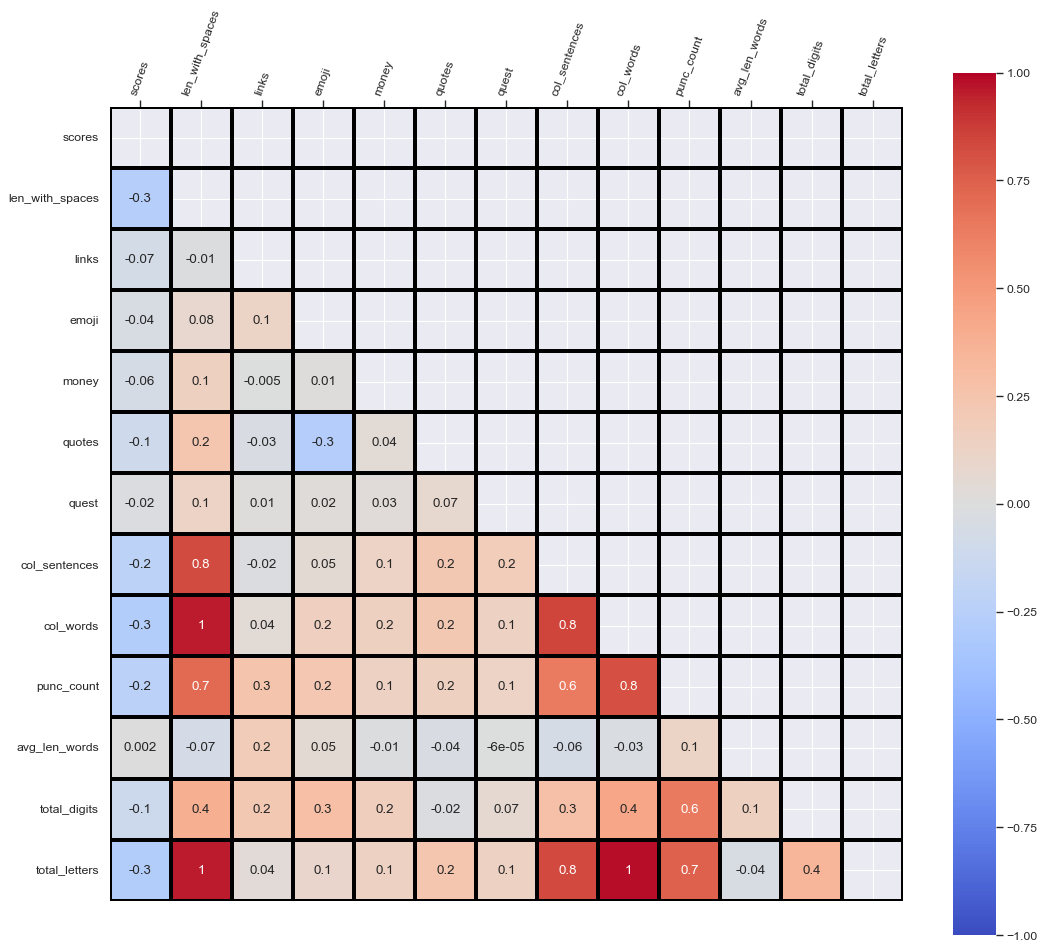

In [432]:
plt.figure(figsize=(16, 14), dpi=80)

ax = sns.heatmap(df.corr(), 
            cmap='coolwarm',
            annot=True,
            linewidths=2,
            linecolor='black',
            square=True,
            mask = np.triu(df.corr()),
            fmt='.1g',
            vmin=-1,
            vmax=1)

ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
sns.set(font_scale=1)

plt.xticks(rotation=70)
plt.savefig('heatmap.png')

Отсеим коррелирующие признаки

In [228]:
df1 = df.drop(['len_with_spaces', 'total_letters'], axis=1)

In [229]:
X1 = df1.drop(['text', 'comments', 'tokenized', 'scores'], axis=1)

In [230]:
Y1 = df1['scores']

In [334]:
X_val = X1[240000:340000]
X_train = X1[:240000].append(X1[340000:], ignore_index=True)

/var/folders/zv/dfxvk8wd299dlnr1hb_m0gkh0000gn/T/ipykernel_17758/4224367671.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X1[:240000].append(X1[340000:], ignore_index=True)


In [335]:
y_val = Y1[240000:340000]
y_train = Y1[:240000].append(Y1[340000:], ignore_index=True)

/var/folders/zv/dfxvk8wd299dlnr1hb_m0gkh0000gn/T/ipykernel_17758/4154242956.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = Y1[:240000].append(Y1[340000:], ignore_index=True)


In [294]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=10000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [295]:
lr_clf.score(X_train, y_train)

0.2784207203371166

In [296]:
lr_clf.score(X_val, y_val)

0.2774378537412422

In [297]:
lr_pred = lr_clf.predict(X_val)
lr_pred_ndcg = lr_pred.reshape((-1,5))

In [298]:
y_val_ndcg = y_val.to_numpy().reshape((-1,5))

In [299]:
from sklearn.metrics import ndcg_score
ndcg_score(y_val_ndcg, lr_pred_ndcg)

0.8575133988702159

In [300]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(500)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=500)

In [301]:
model.score(X_train, y_train)

0.2915001394863964

In [302]:
model.score(X_val, y_val)

0.28518712444211736

In [303]:
model_pred = model.predict(X_val)
model_pred_ndcg = model_pred.reshape((-1,5))

In [304]:
y_val_ndcg = y_val.to_numpy().reshape((-1,5))

In [305]:
from sklearn.metrics import ndcg_score
ndcg_score(y_val_ndcg, model_pred_ndcg)

0.8667607036281795

In [336]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier()
tree.fit(X_train, y_train)

RandomForestClassifier()

In [337]:
tree.score(X_train, y_train)

0.9582656701954277

In [338]:
tree.score(X_val, y_val)

0.25179

In [339]:
tree_pred = tree.predict(X_val)
tree_pred_ndcg = tree_pred.reshape((-1,5))

In [340]:
y_val_ndcg = y_val.to_numpy().reshape((-1,5))

In [341]:
from sklearn.metrics import ndcg_score
ndcg_score(y_val_ndcg, tree_pred_ndcg)

0.8448983785663244

Анализ Текста поста

In [252]:
df['emoji_pic']=df['text'].apply(lambda a: len(emoji.distinct_emoji_list(a)))

In [253]:
df['len_with_spaces_txt'] = [len(i.split(' ')) for i in df.text]

In [254]:
df['links_txt']=df.text.str.contains('www|http').astype('int')

In [255]:
df['money_txt']=df.text.str.contains("$", regex=False).astype('int')

In [256]:
df['quotes_txt']=df.text.str.contains('.*".*".*').astype('int')

In [257]:
df['quest_txt']=df.text.str.contains('?', regex=False).astype('int')

In [258]:
df['col_sentences_txt'] = df.text.apply(lambda a: len(nltk.sent_tokenize(a)))

In [259]:
df['col_words_txt'] = df.text.apply(lambda a: len(nltk.word_tokenize(a)))

In [260]:
punc_count_txt = []
for i in df.text:
    punc_count_txt.append(sum(i.count(char) for char in string.punctuation))

In [261]:
df['punc_count_txt'] = punc_count_txt

In [262]:
df['avg_len_words_txt'] = df["text"].apply(lambda x: np.mean([len(w) for w in x.split()]))

In [263]:
X2 = df.drop(['text', 'comments','tokenized', 'scores'], axis=1)

In [264]:
Y2 = df['scores']

In [342]:
X_val = X2[240000:340000]
X_train = X2[:240000].append(X2[340000:], ignore_index=True)

/var/folders/zv/dfxvk8wd299dlnr1hb_m0gkh0000gn/T/ipykernel_17758/1227675795.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X2[:240000].append(X2[340000:], ignore_index=True)


In [343]:
y_val = Y2[240000:340000]
y_train = Y2[:240000].append(Y2[340000:], ignore_index=True)

/var/folders/zv/dfxvk8wd299dlnr1hb_m0gkh0000gn/T/ipykernel_17758/2221026680.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = Y2[:240000].append(Y2[340000:], ignore_index=True)


In [351]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=10000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [352]:
lr_clf.score(X_train, y_train)

0.2802002730996814

In [353]:
lr_clf.score(X_val, y_val)

0.27699

In [354]:
lr_pred = lr_clf.predict(X_val)
lr_pred_ndcg = lr_pred.reshape((-1,5))

In [355]:
y_val_ndcg = y_val.to_numpy().reshape((-1,5))

In [356]:
from sklearn.metrics import ndcg_score
ndcg_score(y_val_ndcg, lr_pred_ndcg)

0.8568944839867577

In [357]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(500)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=500)

In [358]:
model.score(X_train, y_train)

0.29277460466618704

In [359]:
model.score(X_val, y_val)

0.28367

In [360]:
model_pred = model.predict(X_val)
model_pred_ndcg = model_pred.reshape((-1,5))

In [361]:
y_val_ndcg = y_val.to_numpy().reshape((-1,5))

In [362]:
from sklearn.metrics import ndcg_score
ndcg_score(y_val_ndcg, model_pred_ndcg)

0.865604513773037

In [344]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier()
tree.fit(X_train, y_train)

RandomForestClassifier()

In [345]:
tree.score(X_train, y_train)

0.9998590453257374

In [346]:
tree.score(X_val, y_val)

0.26742

In [347]:
tree_pred = tree.predict(X_val)
tree_pred_ndcg = tree_pred.reshape((-1,5))

In [348]:
y_val_ndcg = y_val.to_numpy().reshape((-1,5))

In [349]:
from sklearn.metrics import ndcg_score
ndcg_score(y_val_ndcg, tree_pred_ndcg)

0.8563372647150138

In [290]:
df.columns

Index(['text', 'comments', 'scores', 'len_with_spaces', 'links', 'emoji',
       'money', 'quotes', 'quest', 'col_sentences', 'tokenized', 'col_words',
       'punc_count', 'avg_len_words', 'total_digits', 'total_letters',
       'emoji_pic', 'len_with_spaces_txt', 'links_txt', 'money_txt',
       'quotes_txt', 'quest_txt', 'col_sentences_txt', 'col_words_txt',
       'punc_count_txt', 'avg_len_words_txt'],
      dtype='object')

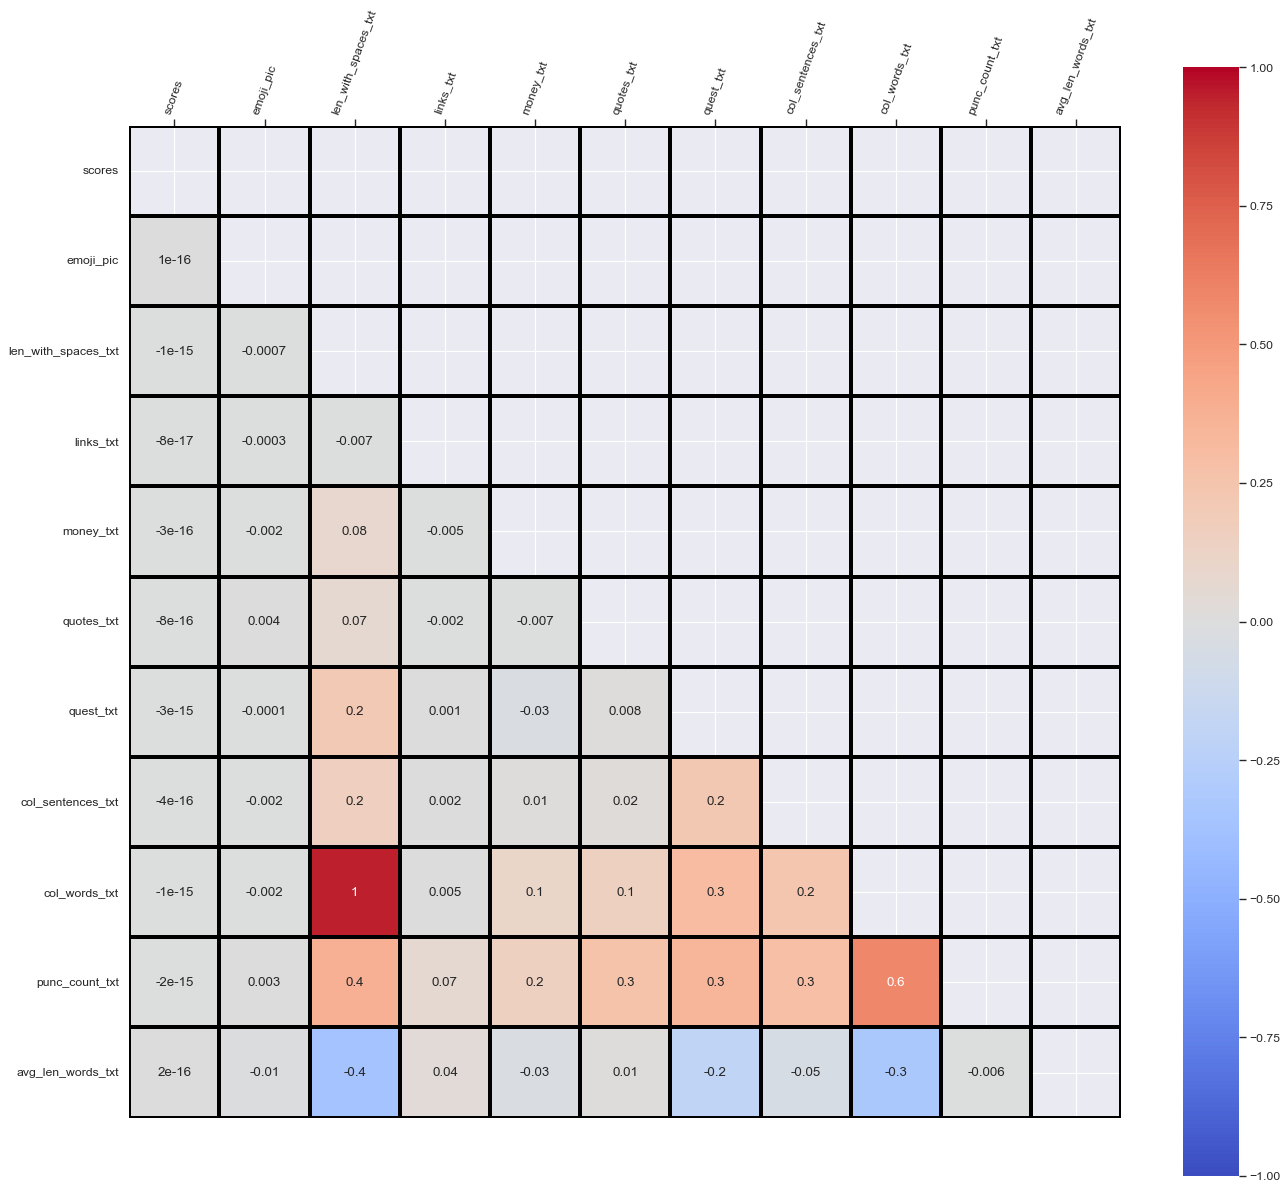

In [291]:
plt.figure(figsize=(20, 18), dpi=80)

ax = sns.heatmap(df[['scores','emoji_pic', 'len_with_spaces_txt', 'links_txt',
                     'money_txt', 'quotes_txt', 'quest_txt', 'col_sentences_txt',
                     'col_words_txt', 'punc_count_txt', 'avg_len_words_txt']].corr(), 
            cmap='coolwarm',
            annot=True,
            linewidths=2,
            linecolor='black',
            square=True,
            mask = np.triu(df[['scores','emoji_pic', 'len_with_spaces_txt', 'links_txt',
                     'money_txt', 'quotes_txt', 'quest_txt', 'col_sentences_txt',
                     'col_words_txt', 'punc_count_txt', 'avg_len_words_txt']].corr()),
            fmt='.1g',
            vmin=-1,
            vmax=1)

ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
sns.set(font_scale=1)

plt.xticks(rotation=70)
plt.savefig('heatmap.png')

Все признаки, которые нам удалось выделить из текстов постов, не показывают особой взаимосвязи со скорами комментариев.

Лучший скор получился на сочетании фичей и метода классификации KNN, теперь предскажем результаты ранжирования для тестовой выборки:

In [433]:
with open('data/ranking_test.jsonl', 'r') as f:
    target = [json.loads(line) for line in f]

rows = []
for d in target:
    text = d['text']
    comments = [c['text'] for c in d['comments']]
    score = [c['score'] for c in d['comments']]
    rows.append({'text': text, 'comments': comments, 'scores':score})

df = pd.DataFrame(rows)

In [434]:
df = df.explode('comments')

In [435]:
unknown = []
for d in target:
    for c in d['comments']:
        unknown.append(c['score'])

In [436]:
df['scores'] = unknown

In [437]:
df.reset_index(drop=True, inplace = True)

In [438]:
df['len_with_spaces'] = [len(i.split(' ')) for i in df.comments]

In [439]:
df['links']=df.comments.str.contains('www|http').astype('int')

In [440]:
df['emoji']=df.comments.str.contains("&#x").astype('int')

In [441]:
df['money']=df.comments.str.contains("$", regex=False).astype('int')

In [442]:
df['quotes']=df.comments.str.contains('.*".*".*').astype('int')

In [443]:
df['quest']=df.comments.str.contains('?', regex=False).astype('int')

In [444]:
df['col_sentences'] = df.comments.apply(lambda a: len(nltk.sent_tokenize(a)))

In [445]:
df['tokenized'] = df.comments.apply(lambda a: nltk.word_tokenize(a))

In [446]:
df['col_words'] = df.tokenized.apply(lambda a: len(a))

In [447]:
punc_count = []
for i in df.comments:
    punc_count.append(sum(i.count(char) for char in string.punctuation))

In [448]:
df['punc_count'] = punc_count

In [449]:
df['avg_len_words'] = df["comments"].apply(lambda x: np.mean([len(w) for w in x.split()]))

In [450]:
df['total_digits'] = df.comments.apply(lambda string: len(re.findall('[0-9]',string)))
df['total_letters'] = df.comments.apply(lambda string: len(re.findall('[A-z]',string)))

In [502]:
df.head()

,text,comments,scores,len_with_spaces,links,emoji,money,quotes,quest,col_sentences,tokenized,col_words,punc_count,avg_len_words,total_digits,total_letters
0,"iOS 8.0.1 released, broken on iPhone 6 models,...",I&#x27;m still waiting for them to stabilize w...,None,27,0,1,0,0,0,2,"[I, &, #, x27, ;, m, still, waiting, for, them...",34,6,4.222222,6,102
1,"iOS 8.0.1 released, broken on iPhone 6 models,...","For those who upgraded, no need to do a restor...",None,23,1,1,0,0,0,2,"[For, those, who, upgraded, ,, no, need, to, d...",52,26,8.434783,21,147
2,"iOS 8.0.1 released, broken on iPhone 6 models,...",Upgraded shortly after it was released and suf...,None,48,0,0,0,0,0,2,"[Upgraded, shortly, after, it, was, released, ...",50,7,4.553191,2,205
3,"iOS 8.0.1 released, broken on iPhone 6 models,...",I think they were under a lot of pressure on t...,None,50,0,1,0,0,0,2,"[I, think, they, were, under, a, lot, of, pres...",58,7,4.510204,4,210
4,"iOS 8.0.1 released, broken on iPhone 6 models,...",Fix for those who already updated: http:&#x2F...,None,8,1,1,0,0,0,1,"[Fix, for, those, who, already, updated, :, ht...",24,24,15.285714,6,77


In [452]:
X = df.drop(['text', 'comments', 'tokenized', 'scores'], axis=1)

In [453]:
mod_pred = model_fin.predict(X)

In [503]:
with open('data/ranking_test.jsonl', 'r') as f:
    target = [json.loads(line) for line in f]

rows = []
for d in target:
    text = d['text']
    comments = [c['text'] for c in d['comments']]
    score = [c['score'] for c in d['comments']]
    rows.append({'text': text, 'comments': comments, 'scores':score})

sol = pd.DataFrame(rows)

In [504]:
sol['scores']=list(mod_pred.reshape((-1,5)))

In [506]:
t = []
for i in range(14004):
    names = sol['comments'][i]
    numbers = sol['scores'][i]

    keys = ['text', 'score']

    zipped = zip(names, numbers)

    dicts = [dict(zip(keys, values)) for values in zipped]
    t.append(dicts)

In [507]:
sol['comments1']=t

In [508]:
sol.drop(['comments', 'scores'], axis =1, inplace=True)

In [522]:
sol = sol.rename(columns={'comments1':'comments'})

In [524]:
output_path = "/Users/speedyracer/Downloads/Cup IT/Data/ranking_test_solution.jsonl"

with open(output_path, "w") as f:
    f.write(sol.to_json(orient='records', lines=True))